In [134]:
# importing two required module 
import numpy as np
import matplotlib.pyplot as plt
import toolz
import optax
import jax.numpy as jnp
import jax
from flax import linen as nn


In [135]:
def get_point_on_a_line(vertex_1,vertex_2,weight):
    """ 
    so we want to get a section between vertex_1,vertex_2 
    we first need to calcualte a slope of the line 
    https://www.w3schools.com/datascience/ds_linear_slope.asp

    then we need to move up on a line with calculated slope as in 
    https://www.geeksforgeeks.org/find-points-at-a-given-distance-on-a-line-of-given-slope/
    """
    #we get a slope
    slope = (vertex_2[1]-vertex_1[0])/(vertex_2[0]-vertex_1[0])
    #now we need a distance travelled on a line
    vertex_diff=vertex_1-vertex_2
    l= np.sqrt(np.dot(vertex_diff,vertex_diff ))*weight

    dx = (l / np.sqrt(1 + (slope * slope)))
    dy = slope * dx
    
    return np.array([vertex_1[0]+dx, vertex_1[1]+dy])



def lineLineIntersection(A, B, C, D):
    """ 
    based on https://www.geeksforgeeks.org/program-for-point-of-intersection-of-two-lines/
    """
    # Line AB represented as a1x + b1y = c1
    a1 = B[1] - A[1]
    b1 = A[0] - B[0]
    c1 = a1*(A[0]) + b1*(A[1])
 
    # Line CD represented as a2x + b2y = c2
    a2 = D[1] - C[1]
    b2 = C[0] - D[0]
    c2 = a2*(C[0]) + b2*(C[1])
    

    determinant = (a1*b2 - a2*b1)+0.000000000001
    
    # if (determinant == 0):
    #     # The lines are parallel. This is simplified
    #     # by returning a pair of FLT_MAX
    #     return Point(10**9, 10**9)
    # else:
    x = (b2*c1 - b1*c2)/determinant
    y = (a1*c2 - a2*c1)/determinant
    return jnp.array([x, y])

def orthoProjection(vertex_a,vertex_b,vertex_c):
    """ 
    projection of a point on a line 
    adapted from https://stackoverflow.com/questions/55230528/find-point-where-altitude-meets-base-python
    """
    # abx = bx - ax
    abx = vertex_b[0] - vertex_a[0]
    # aby = by - ay
    aby = vertex_b[1] - vertex_a[1]
    # acx = cx - ax
    acx = vertex_c[0] - vertex_a[0]
    # acy = cy - ay
    acy = vertex_c[1] - vertex_a[1]
    t = (abx * acx + aby * acy) / ((abx * abx + aby * aby)+0.000000001)
    # px = ax + t * abx
    px = vertex_a[0] + t * abx
    # py = ay + t * aby
    py = vertex_a[1] + t * aby
    return jnp.array([px, py])


def get_point_on_a_line_b(vertex_0,vertex_1,weight):
    diff_x=vertex_1[0]-vertex_0[0]
    diff_y=vertex_1[1]-vertex_0[1]
    # weight=weight/2+1.5
    # weight=(weight*2)

    # C=jnp.array([vertex_0[0]+(diff_x*weight), vertex_0[1]])
    # D=jnp.array([vertex_0[0],vertex_0[1]+(diff_y*weight)])

    # alpha=np.pi/4
    # beta=-np.pi/4
    # a= vertex_0
    # #just multiplied by rotation matrix, we divide by square root of 2 in order to keep the weights in domain 1 to two
    # C= np.array([  a[0]*np.cos(alpha) + a[1]*np.sin(alpha), -a[0]*np.sin(alpha) + a[1]*np.cos(alpha)])/np.sqrt(2)
    # D= np.array([  a[0]*np.cos(beta) + a[1]*np.sin(beta), -a[0]*np.sin(beta) + a[1]*np.cos(beta)])/np.sqrt(2)
    
    # C=C*weight
    # D=D*weight
    # print(f"C {C} D {D} diff_x {diff_x} diff_y {diff_y}  vertex_0[0]{vertex_0[0]} diff_x*weight {diff_x*weight} sum {vertex_0[0]+(diff_x*weight)}")
    # return lineLineIntersection(vertex_0, vertex_1, C, D)
    return np.array([vertex_0[0]+(diff_x*weight),vertex_0[1]+(diff_y*weight)])

def get_point_on_a_line_c(vertex_0,vertex_1,weight):
    # diff_x=vertex_1[0]-vertex_0[0]
    # diff_y=vertex_1[1]-vertex_0[1]
    weight=weight/2+1.5
    # weight=(weight*2)

    # C=jnp.array([vertex_0[0]+(diff_x*weight), vertex_0[1]])
    # D=jnp.array([vertex_0[0],vertex_0[1]+(diff_y*weight)])

    alpha=np.pi/4
    beta=-np.pi/4
    a= vertex_0
    #just multiplied by rotation matrix, we divide by square root of 2 in order to keep the weights in domain 1 to two
    C= np.array([  a[0]*np.cos(alpha) + a[1]*np.sin(alpha), -a[0]*np.sin(alpha) + a[1]*np.cos(alpha)])/np.sqrt(2)
    D= np.array([  a[0]*np.cos(beta) + a[1]*np.sin(beta), -a[0]*np.sin(beta) + a[1]*np.cos(beta)])/np.sqrt(2)
    
    C=C*weight
    D=D*weight
    # print(f"C {C} D {D} diff_x {diff_x} diff_y {diff_y}  vertex_0[0]{vertex_0[0]} diff_x*weight {diff_x*weight} sum {vertex_0[0]+(diff_x*weight)}")
    return lineLineIntersection(vertex_0, vertex_1, C, D)




""" 
we want to put a new point in a triangle - that will be a new control point
point is as specified constrained by a triangle weights live on each of the primary triangle edges
so we take all three edges establish positions of temporary points by moving on those edges by percentege of their length
    taken from (sigmoided) weights we get a section by connecting two points and we get a final output point by projecting the third point on to the
    described section between previous 2 points
"""
def get_point_inside_triange(vertex_a,vertex_b,vertex_c,edge_weights):
    p0=get_point_on_a_line_b(vertex_a,vertex_b,edge_weights[0])
    p1=get_point_on_a_line_b(vertex_b,vertex_c,edge_weights[1])
    p2=get_point_on_a_line_b(vertex_c,vertex_a,edge_weights[2])
    print(f"p0 {p0} p1 {p1} p2 {p2}")
    return orthoProjection(p0,p1,p2),p0,p1,p2





[ 3.  -1.7]


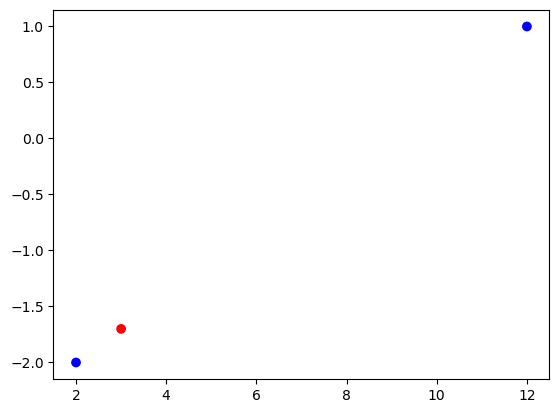

In [140]:
b=np.array([12,1])
a=np.array([2,-2])
# c=get_point_on_a_line_b(b,a,-0.3)
c=get_point_on_a_line_b(b,a,0.9)
print(c)
points_const= np.stack([b,a,c])
X,Y=list(toolz.sandbox.core.unzip(points_const))
X=list(X)
Y=list(Y)
plt.scatter(X,Y,color=['blue','blue','red'])
plt.show()